#Libraries


In [21]:
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import itertools

plt.style.use('dark_background')

# Load data
Select the file containing the data

In [2]:
from google.colab import files
archive = files.upload()

Read CSV and load data

In [3]:
df = pd.read_csv("dengue_features_train.csv", sep=",")
df

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


Select only the period asignated

In [4]:
#Look for those rows that has a value between 1992 and 1998 on the field 'year' 
#And make sure that the value in the 'city' field is 'sj'
data = df[df['year'].between(1992,1998)][df['city'].str.contains('sj')]
data = data.reset_index(drop=True)
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1992,1,1992-01-01,0.125100,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sj,1992,2,1992-01-08,0.100833,0.073575,0.138714,0.112786,200.85,297.912857,298.121429,294.457143,300.4,296.1,18.30,81.300000,200.85,15.878571,2.300000,25.657143,7.500000,30.6,20.6,58.2
2,sj,1992,3,1992-01-15,0.222400,0.229900,0.198457,0.199414,3.12,297.338571,297.485714,294.467143,300.2,295.6,19.80,84.117143,3.12,15.832857,1.857143,25.471429,6.171429,31.1,21.7,32.3
3,sj,1992,4,1992-01-22,0.122533,0.131050,0.188843,0.168871,0.00,297.091429,297.335714,293.021429,299.5,295.6,5.11,78.291429,0.00,14.482857,2.357143,24.857143,7.442857,30.6,20.0,1.3
4,sj,1992,5,1992-01-29,NaN,0.048300,0.173671,0.191929,0.00,297.420000,297.550000,292.718571,299.3,295.5,6.50,75.220000,0.00,14.185714,2.442857,24.800000,6.585714,28.9,20.0,9.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,sj,1998,48,1998-11-26,0.050100,0.065750,0.166243,0.146757,0.00,299.232857,299.321429,295.492857,301.4,297.4,57.10,80.021429,0.00,16.867143,2.014286,26.557143,5.685714,30.0,22.8,29.8
360,sj,1998,49,1998-12-03,0.056750,0.065650,0.069186,0.052786,22.35,298.301429,298.257143,295.172857,300.4,296.5,115.77,83.024286,22.35,16.587143,1.885714,25.642857,5.942857,29.4,22.2,48.2
361,sj,1998,50,1998-12-10,0.061900,0.002633,0.213300,0.173014,152.94,298.094286,298.150000,295.540000,299.8,297.1,158.72,85.911429,152.94,16.965714,1.357143,25.814286,5.014286,28.9,22.8,97.6
362,sj,1998,51,1998-12-17,-0.082167,-0.091675,0.239900,0.170057,16.76,299.042857,299.100000,295.032857,300.9,297.6,10.20,78.668571,16.76,16.408571,1.971429,26.071429,5.542857,31.1,22.8,18.9


#Transform Data

In [5]:
data = data.loc[:, data.columns.difference(['city'])]
column = data['week_start_date']
data = data.loc[:, data.columns.difference(['week_start_date'])]
data.describe

<bound method NDFrame.describe of       ndvi_ne   ndvi_nw   ndvi_se  ...  station_precip_mm  weekofyear  year
0    0.125100  0.157867  0.185283  ...                NaN           1  1992
1    0.100833  0.073575  0.138714  ...               58.2           2  1992
2    0.222400  0.229900  0.198457  ...               32.3           3  1992
3    0.122533  0.131050  0.188843  ...                1.3           4  1992
4         NaN  0.048300  0.173671  ...                9.2           5  1992
..        ...       ...       ...  ...                ...         ...   ...
359  0.050100  0.065750  0.166243  ...               29.8          48  1998
360  0.056750  0.065650  0.069186  ...               48.2          49  1998
361  0.061900  0.002633  0.213300  ...               97.6          50  1998
362 -0.082167 -0.091675  0.239900  ...               18.9          51  1998
363  0.060567 -0.130950  0.157150  ...               29.7          52  1998

[364 rows x 22 columns]>

Lets check if we have null values in any field

In [6]:
data[data.isnull().any(axis=1)]

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,year
0,0.12510,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1992
4,NaN,0.048300,0.173671,0.191929,0.00,297.420000,297.550000,292.718571,299.3,295.5,6.50,75.220000,0.00,14.185714,2.442857,24.800000,6.585714,28.9,20.0,9.2,5,1992
6,NaN,0.130500,0.195743,0.178857,NaN,297.798571,298.057143,294.650000,300.2,295.3,20.10,82.875714,NaN,16.060000,2.200000,26.028571,6.571429,32.2,20.0,1.3,7,1992
7,NaN,0.184467,0.194614,0.203057,NaN,297.898571,298.107143,293.628571,300.1,296.3,4.40,77.295714,NaN,15.012857,2.585714,25.757143,7.385714,33.9,21.7,8.9,8,1992
8,0.10705,0.081500,0.165243,0.163057,NaN,297.472857,297.678571,292.967143,299.3,296.3,14.40,76.037143,NaN,14.381429,2.414286,25.285714,6.171429,29.4,21.7,16.0,9,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,NaN,0.040100,0.155483,0.141480,35.03,300.587143,300.607143,297.275714,303.0,298.8,33.83,82.332857,35.03,18.847143,2.185714,28.728571,6.985714,34.4,24.4,39.7,38,1998
352,NaN,-0.019000,0.163057,0.149200,33.26,300.712857,300.742857,296.921429,302.9,298.9,28.30,79.998571,33.26,18.418571,2.342857,28.257143,5.500000,31.7,24.4,25.0,41,1998
353,NaN,0.081550,0.186414,0.138686,25.94,300.795714,300.857143,296.612857,302.9,299.3,18.50,78.098571,25.94,18.091429,2.685714,27.757143,6.314286,31.7,23.3,15.5,42,1998
356,NaN,-0.002250,0.221229,0.169800,121.65,299.652857,299.692857,296.942857,301.7,298.5,89.50,85.120000,121.65,18.484286,1.785714,27.428571,6.457143,31.1,23.3,81.5,45,1998


Oh, there are null values D:

We are going to drop the first row as it has several fields with NaN values

In [7]:
data = data.drop(0) # Eliminate first row (contains several NaN values)
data

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,year
1,0.100833,0.073575,0.138714,0.112786,200.85,297.912857,298.121429,294.457143,300.4,296.1,18.30,81.300000,200.85,15.878571,2.300000,25.657143,7.500000,30.6,20.6,58.2,2,1992
2,0.222400,0.229900,0.198457,0.199414,3.12,297.338571,297.485714,294.467143,300.2,295.6,19.80,84.117143,3.12,15.832857,1.857143,25.471429,6.171429,31.1,21.7,32.3,3,1992
3,0.122533,0.131050,0.188843,0.168871,0.00,297.091429,297.335714,293.021429,299.5,295.6,5.11,78.291429,0.00,14.482857,2.357143,24.857143,7.442857,30.6,20.0,1.3,4,1992
4,NaN,0.048300,0.173671,0.191929,0.00,297.420000,297.550000,292.718571,299.3,295.5,6.50,75.220000,0.00,14.185714,2.442857,24.800000,6.585714,28.9,20.0,9.2,5,1992
5,0.101600,0.084600,0.111717,0.187957,0.00,296.920000,297.128571,292.617143,300.7,294.5,16.20,77.058571,0.00,14.122857,3.400000,24.714286,7.357143,30.6,20.0,3.0,6,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.050100,0.065750,0.166243,0.146757,0.00,299.232857,299.321429,295.492857,301.4,297.4,57.10,80.021429,0.00,16.867143,2.014286,26.557143,5.685714,30.0,22.8,29.8,48,1998
360,0.056750,0.065650,0.069186,0.052786,22.35,298.301429,298.257143,295.172857,300.4,296.5,115.77,83.024286,22.35,16.587143,1.885714,25.642857,5.942857,29.4,22.2,48.2,49,1998
361,0.061900,0.002633,0.213300,0.173014,152.94,298.094286,298.150000,295.540000,299.8,297.1,158.72,85.911429,152.94,16.965714,1.357143,25.814286,5.014286,28.9,22.8,97.6,50,1998
362,-0.082167,-0.091675,0.239900,0.170057,16.76,299.042857,299.100000,295.032857,300.9,297.6,10.20,78.668571,16.76,16.408571,1.971429,26.071429,5.542857,31.1,22.8,18.9,51,1998


Now we deal with the rest of the features that has a NaN value. What we are going to do is to substitute the NaN values in each feature for the mean corresponding to that feature.

To do that, we are going to take which features has a NaN value and then get the mean and fill the NaN values with the mean of that feature.

In [8]:
nan_features = data.columns[data.isna().any()].tolist()
nan_features

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

Now we fill the NaN values with the mean of each corresponding feature.

In [9]:
data = data.fillna(data.mean())

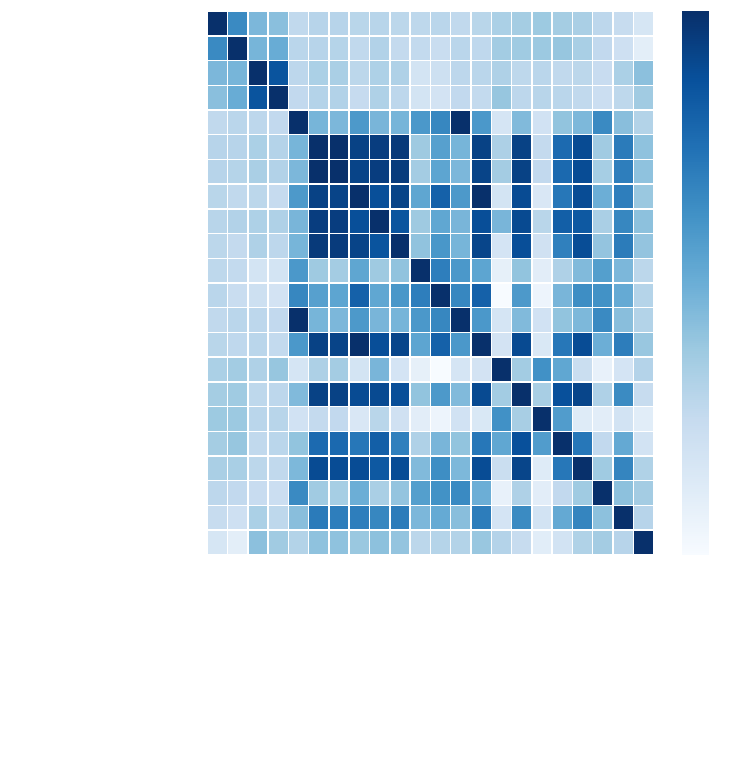

In [10]:
corrMatrix = data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, linewidths=.5, ax=ax, cmap="Blues")
plt.show()

In [11]:
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

data = data.drop(data[to_drop], axis=1)

Now we check the correlation again once we have done the feature reduction.

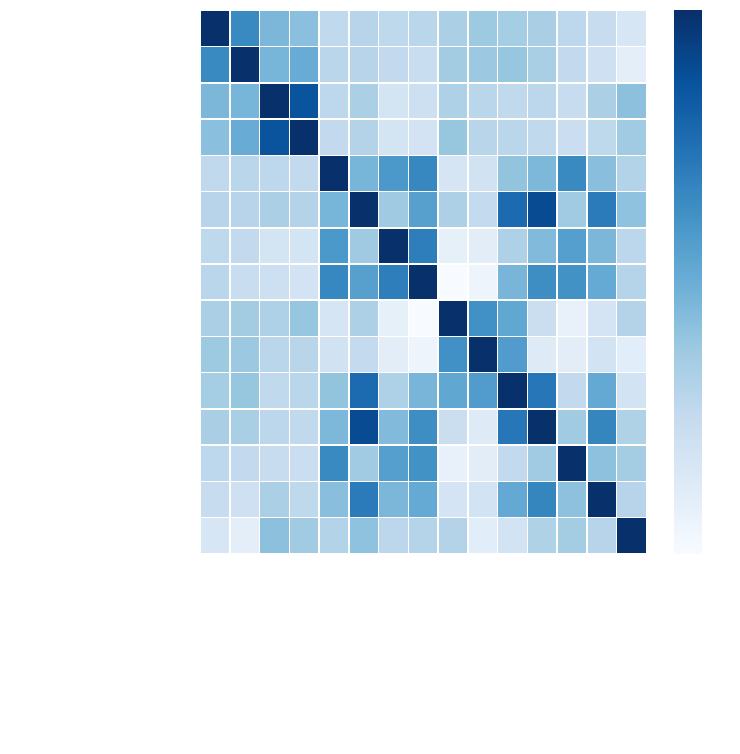

In [12]:
corrMatrix = data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, linewidths=.5, ax=ax, cmap="Blues")
plt.show()

Let's detect if there are any outliers.

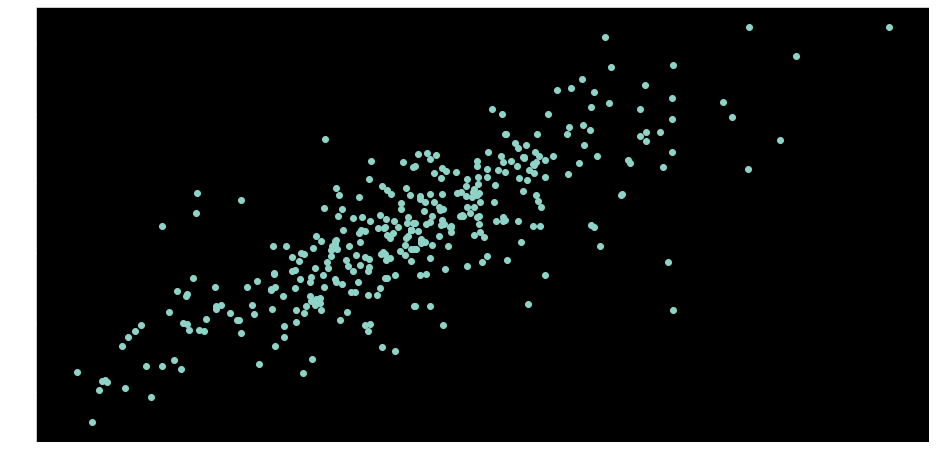

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data["ndvi_se"], data["ndvi_sw"])
plt.show()

Preproceso para normalización del dataset

In [32]:
from sklearn import preprocessing 

scaler = preprocessing.StandardScaler()
preprocessedData = scaler.fit_transform(data)

preprocessedData

array([[ 0.37228656, -0.19893848, -0.72075647, ...,  1.06013032,
        -1.64105767, -1.50674161],
       [ 2.07589649,  2.25784339,  0.5029418 , ...,  0.19850719,
        -1.57427471, -1.50674161],
       [ 0.67638576,  0.7043306 ,  0.30601631, ..., -0.83277918,
        -1.50749176, -1.50674161],
       ...,
       [-0.17331644, -1.31384781,  0.80696557, ...,  2.37086203,
         1.56452403,  1.49846281],
       [-2.19223617, -2.79598441,  1.35180736, ..., -0.24727466,
         1.63130699,  1.49846281],
       [-0.19200144, -3.41322482, -0.3431422 , ...,  0.1120122 ,
         1.69808994,  1.49846281]])

In [23]:
# PCA Estimation
from sklearn.decomposition import PCA

pca = PCA ()
X_pca = pca.fit_transform(preprocessedData)
X_pca.shape

(363, 15)

In [29]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.line(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [31]:
fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1])

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1])
fig.show()

- ~Correlaccion para eliminar las caracteristicas redundantes~
- ~NaN se sustituyen por la media (o el forward field [algo asi])~
- ~Normalizar~
- ~Hacer PCA~

##DUDAS

- Preguntar por eliminacion de variales muy correladas (quitamos ahora mismo valores > 0.9)
- Preguntar por normalizacion (valores superiores a 1 e inferiores a 0)
REVISAR CUADERNO DE K-MEANS